In [1]:
import torch
import torch.utils.data as Data
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage()#可以把Tensor转变为Image


In [2]:
#定义数据的预处理
transform = transforms.Compose([
    transforms.ToTensor(),#转换为Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),#归一化
])
#训练集
trainset = tv.datasets.CIFAR10(
                               root='/data/',
                               train=True,
                               download=True,
                               transform=transform)
    

trainloader = Data.DataLoader(
                                      trainset,
                                      batch_size=16,
                                      shuffle=True,
                                      num_workers=2,
                                      )
testset = tv.datasets.CIFAR10(
                              root='/data/',
                              train=False,
                              download=True,
                              transform=transform)

testloader = Data.DataLoader(
                                     testset,
                                     batch_size=16,
                                     shuffle=False,
                                     num_workers=2,
)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


ship


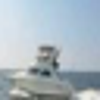

In [3]:
(data, label) = trainset[100]
print(classes[label])
show((data+1)/2).resize((100, 100))

  deer  plane  plane    dog   bird    car   bird    cat    dog  plane  plane    car  plane  horse  horse    car


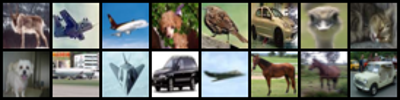

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(' '.join('%6s'%classes[labels[j]] for j in range(16)))
show(tv.utils.make_grid((images+1)/2)).resize((400, 100))

In [5]:
#define Net
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
print(net)



Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [6]:
#define loss function and optim
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [7]:
torch.set_num_threads(8)
for epoch in range(8):  
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # 输入数据
        inputs, labels = data
        
        # 梯度清零
        optimizer.zero_grad()
        
        # forward + backward 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()   
        
        # 更新参数 
        optimizer.step()
        
        # 打印log信息
        # loss 是一个scalar,需要使用loss.item()来获取数值，不能使用loss[0]
        running_loss += loss.item()
        if i % 2000 == 1999: # 每2000个batch打印一下训练状态
            print('[%d, %5d] loss: %.3f' \
                  % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')
    

[1,  2000] loss: 2.118
[2,  2000] loss: 1.580
[3,  2000] loss: 1.406
[4,  2000] loss: 1.304
[5,  2000] loss: 1.208
[6,  2000] loss: 1.150
[7,  2000] loss: 1.084
[8,  2000] loss: 1.040
Finished Training


real label:       cat     ship     ship    plane     frog     frog      car     frog      cat      car    plane    truck      dog    horse    truck     ship


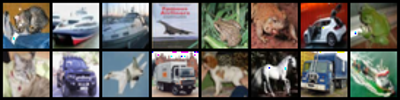

In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print('real label: ', ' '.join(\
                              '%08s'%classes[labels[j]] for j in range(16)))
show(tv.utils.make_grid(images/2-0.5)).resize((400, 100))

In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
print("%d%%"%(100*correct/total))

61%


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)
images = images.to(device)
labels = labels.to(device)
output = net(images)
loss= criterion(output,labels)

loss

tensor(1.2318, device='cuda:0', grad_fn=<NllLossBackward0>)